In [24]:
import uproot
from pathlib import Path
from typing import Union
import logging
import numpy as np
from matplotlib import pyplot as plt
import hist
import pandas as pd
import mplhep as hep

hep.style.use(hep.style.ATLAS)

from utils.histograms import (
    TH1tohist,
    histtoTH1,
    RebinTH1,
    Rebinhist,
)
from utils.constants import myoutput_path
from utils.processing import (
    logging_setup,
    check_inputpath,
    check_outputpath,
)

In [2]:
histograms1 = uproot.open("/data/hrzhao/Samples/Run2_WZ/Finebin/ExportHistograms.root")
histograms2 = uproot.open(
    "/data/hrzhao/Samples/ssWWWZ_run3/information_Run2_WZHp/fit_inputs/histograms/Final/regularGMANN.root"
)

In [54]:
# hist_identifiers = ["WZEW", "WZQCD", "VVV", "ZZ", "data"]
# "FakeRenorm" is gone in regularGMANN.root
region_labels = ["GMMVASR", "GMMVACR", "ZZCRJJ"]
m_WZ_bin_edges = np.array([150, 200, 230, 270, 310, 350, 390, 480, 660, 1200])
m_WZ_bin_widths = np.diff(m_WZ_bin_edges)
# sig_mass_WZ = [200, 300, 350, 500]
sig_mass_WZ = [
    200,
    225,
    250,
    275,
    300,
    325,
    350,
    375,
    400,
    425,
    450,
    475,
    500,
    525,
    550,
    600,
    700,
    800,
    900,
    1000,
]

# Compare bkgs 

In [6]:
histogram_names = []
for histograms in [histograms1, histograms2]:
    SR_names = histograms.keys(filter_name="*_M_WZ_GMMVASR", cycle=False, recursive=False)
    SR_names = [_SR_name for _SR_name in SR_names if not _SR_name.startswith("HVT")]
    bkg_SR_names = [_SR_name for _SR_name in SR_names if not _SR_name.startswith("GMvbf")]
    histogram_names.append(bkg_SR_names)

In [12]:
common_histograms = list(set(histogram_names[0]) & set(histogram_names[1]))

In [19]:
histogram1_names = common_histograms + np.setdiff1d(histogram_names[0], common_histograms).tolist()

In [20]:
histogram2_names = common_histograms + np.setdiff1d(histogram_names[1], common_histograms).tolist()

In [29]:
pd.DataFrame([histogram1_names, histogram2_names], ["ExportHistograms.root", "regularGMANN.root"]).T

,ExportHistograms.root,regularGMANN.root
0,WZEW_M_WZ_GMMVASR,WZEW_M_WZ_GMMVASR
1,WZQCD_M_WZ_GMMVASR,WZQCD_M_WZ_GMMVASR
2,data_M_WZ_GMMVASR,data_M_WZ_GMMVASR
3,Matrix_M_WZ_GMMVASR,Matrix_M_WZ_GMMVASR
4,Top_M_WZ_GMMVASR,Top_M_WZ_GMMVASR
5,ZZ_M_WZ_GMMVASR,ZZ_M_WZ_GMMVASR
6,Asimov_M_WZ_GMMVASR,Asimov_M_WZ_GMMVASR
7,Zjet_M_WZ_GMMVASR,Zjet_M_WZ_GMMVASR
8,VVV_M_WZ_GMMVASR,VVV_M_WZ_GMMVASR
9,Zgamma_M_WZ_GMMVASR,Zgamma_M_WZ_GMMVASR


# Ratio plots of bkgs 

In [49]:
hist_identifiers = [common_histogram.split("_")[0] for common_histogram in common_histograms]

In [ ]:
bkg_hists = dict.fromkeys(region_labels)
for region_label in region_labels:
    output_path = check_outputpath(f"comparision_plots/backgrounds/{region_label}")
    bkg_hists[region_label] = {}
    for hist_identifier in hist_identifiers:
        hist_name = f"{hist_identifier}_M_WZ_{region_label}"  # WZEW_M_WZ_GMMVASR
        unbined_hist = histograms1[hist_name].to_hist()
        rebined_hist = Rebinhist(unbined_hist, m_WZ_bin_edges)

        # Merge the overflow bin to the last bin
        rebined_hist[-1] += rebined_hist[hist.overflow]
        rebined_hist[0] += rebined_hist[hist.underflow]
        rebined_hist[hist.overflow] = (0.0, 0.0)
        rebined_hist[hist.underflow] = (0.0, 0.0)
        hist1 = rebined_hist.copy()

        _hist2 = histograms2[hist_name].to_hist()
        hist2 = hist.Hist(
            hist.axis.Variable(m_WZ_bin_edges, flow=True),
            storage=hist.storage.Weight(),
        )
        hist2[:] = _hist2.view()

        fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0})
        main_ax_artists, sublot_ax_arists = hist1.plot_ratio(
            hist2,
            ax_dict={"main_ax": ax[0], "ratio_ax": ax[1]},
            rp_ylabel=r"Ratio",
            rp_num_label="FineBin.root",
            rp_denom_label="regularGMANN.root",
            rp_uncert_draw_type="bar",  # line or bar
            rp_ylim=[0.5, 1.5],
        )
        ax[0].set_ylabel("Yields")
        ax[1].set_xlabel(r"$m_{WZ}$ [GeV]")
        fig.suptitle(hist_name)
        fig.savefig(output_path / f"{hist_name}.png")

        bkg_hists[region_label][hist_name] = [hist1, hist2]

        plt.close(fig)

## Check unique hists

In [86]:
hist1_VVV_SR = histograms1["VVV_M_WZ_GMMVASR"].to_hist()


hist2_ttbarV_SR = histograms2["ttbarV_M_WZ_GMMVASR"].to_hist()
hist2_VVV_SR = histograms2["VVV_M_WZ_GMMVASR"].to_hist()
hist2_VVttbar_merge = hist2_ttbarV_SR + hist2_VVV_SR

In [87]:
rebined_hist = Rebinhist(hist1_VVV_SR, m_WZ_bin_edges)

# Merge the overflow bin to the last bin
rebined_hist[-1] += rebined_hist[hist.overflow]
rebined_hist[0] += rebined_hist[hist.underflow]
rebined_hist[hist.overflow] = (0.0, 0.0)
rebined_hist[hist.underflow] = (0.0, 0.0)
hist1_VVV_SR = rebined_hist.copy()

hist2_VVttbar_SR = hist.Hist(
    hist.axis.Variable(m_WZ_bin_edges, flow=True),
    storage=hist.storage.Weight(),
)
hist2_VVttbar_SR[:] = hist2_VVttbar_merge.view()

Warning in <TROOT::Append>: Replacing existing TH1: xaxis (Potential memory leak).


In [88]:
hist1_VVV_SR.plot

Hist(Variable([150, 200, 230, 270, 310, 350, 390, 480, 660, 1200], name='xaxis'), storage=Weight()) # Sum: WeightedSum(value=0.818494, variance=0.198887)

In [89]:
hist2_VVttbar_SR

Hist(Variable([150, 200, 230, 270, 310, 350, 390, 480, 660, 1200], label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=0.825159, variance=0.00440774)

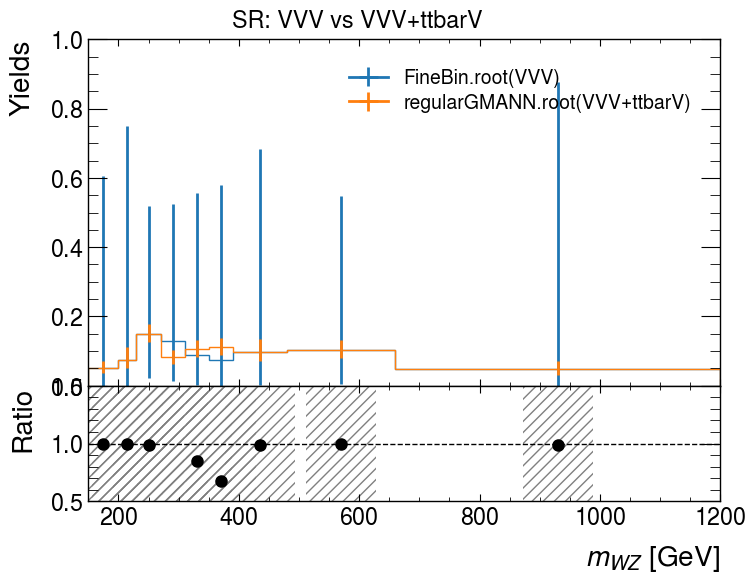

In [92]:
fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0})
main_ax_artists, sublot_ax_arists = hist1_VVV_SR.plot_ratio(
    hist2_VVttbar_SR,
    ax_dict={"main_ax": ax[0], "ratio_ax": ax[1]},
    rp_ylabel=r"Ratio",
    rp_num_label="FineBin.root(VVV)",
    rp_denom_label="regularGMANN.root(VVV+ttbarV)",
    rp_uncert_draw_type="bar",  # line or bar
    rp_ylim=[0.5, 1.5],
)
ax[0].set_ylabel("Yields")
ax[1].set_xlabel(r"$m_{WZ}$ [GeV]")
fig.suptitle("SR: VVV vs VVV+ttbarV ")

fig.savefig("VVV_SR.png", dpi=300, bbox_inches="tight")

fig.savefig("comparision_plots/backgrounds/GMMVASR/VVV_vs_VVVttbarV.png", bbox_inches="tight")

In [103]:
# for signal
sig_hists = dict.fromkeys(region_labels)
for region_label in region_labels:
    sig_output_path = check_outputpath(f"comparision_plots/signal/{region_label}")
    sig_hists[region_label] = {}

    for wp_mass in sig_mass_WZ:
        hist_identifier = f"GMvbf{wp_mass}"
        hist_name = f"{hist_identifier}_M_WZ_{region_label}"  # WZEW_M_WZ_GMMVASR
        unbined_hist = histograms1[hist_name].to_hist()
        rebined_hist = Rebinhist(unbined_hist, m_WZ_bin_edges)

        # Merge the overflow bin to the last bin
        rebined_hist[-1] += rebined_hist[hist.overflow]
        rebined_hist[0] += rebined_hist[hist.underflow]
        rebined_hist[hist.overflow] = (0.0, 0.0)
        rebined_hist[hist.underflow] = (0.0, 0.0)
        hist1 = rebined_hist.copy()

        _hist2 = histograms2[hist_name].to_hist()
        hist2 = hist.Hist(
            hist.axis.Variable(m_WZ_bin_edges, flow=True),
            storage=hist.storage.Weight(),
        )
        hist2[:] = _hist2.view()

        try:
            fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0})
            main_ax_artists, sublot_ax_arists = hist1.plot_ratio(
                hist2,
                ax_dict={"main_ax": ax[0], "ratio_ax": ax[1]},
                rp_ylabel=r"Ratio",
                rp_num_label="FineBin.root",
                rp_denom_label="regularGMANN.root",
                rp_uncert_draw_type="bar",  # line or bar
                rp_ylim=[0.5, 1.5],
            )
            ax[0].set_ylabel("Yields")
            ax[1].set_xlabel(r"$m_{WZ}$ [GeV]")
            fig.suptitle(hist_name)
            fig.savefig(sig_output_path / f"{hist_name}.png")
        except:
            print(f"Error in plotting {hist_name}")
        plt.close()

        sig_hists[region_label][hist_identifier] = [hist1, hist2]

/data/hrzhao/sw/miniconda3/envs/ssWWWZjj/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/data/hrzhao/sw/miniconda3/envs/ssWWWZjj/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/data/hrzhao/sw/miniconda3/envs/ssWWWZjj/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/data/hrzhao/sw/miniconda3/envs/ssWWWZjj/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/data/hrzhao/sw/miniconda3/envs/ssWWWZjj/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/data/hrzhao/sw/miniconda3/envs/ssWWWZjj/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWa

# Count Yield

In [106]:
dict_bkg_yield = {}
for k, v in bkg_hists["GMMVASR"].items():
    dict_bkg_yield[k] = [_v.values().sum() for _v in v]

In [107]:
pd.DataFrame.from_dict(
    dict_bkg_yield, orient="index", columns=["ExportHistograms.root", "regularGMANN.root"]
)

,ExportHistograms.root,regularGMANN.root
WZEW_M_WZ_GMMVASR,25.075573,25.250463
WZQCD_M_WZ_GMMVASR,36.525549,36.819763
data_M_WZ_GMMVASR,66.000000,66.000000
Matrix_M_WZ_GMMVASR,0.262894,0.076550
Top_M_WZ_GMMVASR,0.633001,0.644789
ZZ_M_WZ_GMMVASR,4.559074,4.591837
Asimov_M_WZ_GMMVASR,62.415449,62.931093
Zjet_M_WZ_GMMVASR,1.719329,1.763063
VVV_M_WZ_GMMVASR,0.818494,0.177845
Zgamma_M_WZ_GMMVASR,1.023231,1.023403


In [108]:
dict_sig_yield = {}
for k, v in sig_hists["GMMVASR"].items():
    dict_sig_yield[k] = [_v.values().sum() for _v in v]

pd.DataFrame.from_dict(
    dict_sig_yield, orient="index", columns=["ExportHistograms.root", "regularGMANN.root"]
)

,ExportHistograms.root,regularGMANN.root
GMvbf200,65.254684,65.615516
GMvbf225,55.733855,56.255913
GMvbf250,61.327891,61.785085
GMvbf275,65.351852,65.828960
GMvbf300,63.310598,63.806241
GMvbf325,63.302883,63.813131
GMvbf350,63.243590,63.713041
GMvbf375,58.899455,59.408548
GMvbf400,63.359233,63.785140
GMvbf425,55.464461,55.865735


# Data Renormalization 

In [112]:
data_hists = bkg_hists["GMMVASR"]["data_M_WZ_GMMVASR"]

In [113]:
normalized_data_hists = []
for data_hist in data_hists:
    normalized_data_hists.append(data_hist / m_WZ_bin_widths * 50.0)

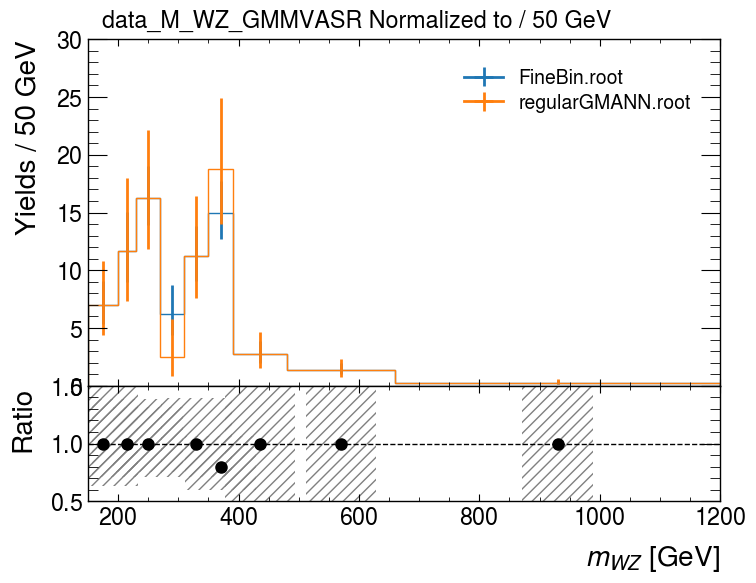

In [116]:
fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0})
main_ax_artists, sublot_ax_arists = normalized_data_hists[0].plot_ratio(
    normalized_data_hists[1],
    ax_dict={"main_ax": ax[0], "ratio_ax": ax[1]},
    rp_ylabel=r"Ratio",
    rp_num_label="FineBin.root",
    rp_denom_label="regularGMANN.root",
    rp_uncert_draw_type="bar",  # line or bar
    rp_ylim=[0.5, 1.5],
)
ax[0].set_ylabel("Yields / 50 GeV")
ax[1].set_xlabel(r"$m_{WZ}$ [GeV]")
fig.suptitle("data_M_WZ_GMMVASR Normalized to / 50 GeV ")

fig.savefig("comparision_plots/backgrounds/GMMVASR/data.png", bbox_inches="tight")